In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import os

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [69]:
os.chdir(r'C:\SML_Projects\SML_CVE_type_cwe_predict')

In [70]:
x_train = pd.read_csv('data/engineered/engineered_x_train.csv')
x_test = pd.read_csv('data/engineered/engineered_x_test.csv')

y_train = pd.read_csv('data/split/y_train.csv')
y_test = pd.read_csv('data/split/y_test.csv')

In [71]:
from joblib import load

pipeline = load('pipeline/full_pipeline.joblib')

c:\SML_Projects\SML_CVE_type_cwe_predict\venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\SML_Projects\SML_CVE_type_cwe_predict\venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\SML_Projects\SML_CVE_type_cwe_predict\venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingClas

In [72]:
from joblib import load

pipeline = load('pipeline/full_pipeline.joblib')

preprocess = pipeline.named_steps['prep']
model_only = pipeline.named_steps['model']

scaler = preprocess.scalers["numeric"]

print(x_train.dtypes)

X_train_trans = preprocess.transform(x_train)
X_test_trans  = preprocess.transform(x_test)

feature_names = preprocess.scalers["numeric"].feature_names_in_

c:\SML_Projects\SML_CVE_type_cwe_predict\venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\SML_Projects\SML_CVE_type_cwe_predict\venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\SML_Projects\SML_CVE_type_cwe_predict\venv\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingClas

cve_id                         object
description                    object
cwe                            object
vendor                         object
product                        object
publish_date                   object
vendor_freq                   float64
product_freq                  float64
desc_len                        int64
desc_word_count                 int64
desc_num_count                  int64
desc_upper_ratio              float64
desc_exclamation                int64
desc_question                   int64
vendor_product_interaction    float64
XSS_score                       int64
SQLi_score                      int64
RCE_score                       int64
DoS_score                       int64
CSRF_score                      int64
AuthBypass_score                int64
PrivEsc_score                   int64
PathTraversal_score             int64
SSRF_score                      int64
InfoDisclosure_score            int64
Other_score                     int64
cvss_keyword

# Global SHAP

In [73]:
num_cols = x_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = x_train.select_dtypes(include=["object"]).columns.tolist()

X_train_enc = x_train[num_cols].copy()
X_test_enc  = x_test[num_cols].copy()

In [74]:
target_id = 0
base_model = model_only.estimators_[target_id]

explainer = shap.TreeExplainer(base_model)
X_sample = X_test_trans[:500]

shap_values = explainer.shap_values(X_sample)

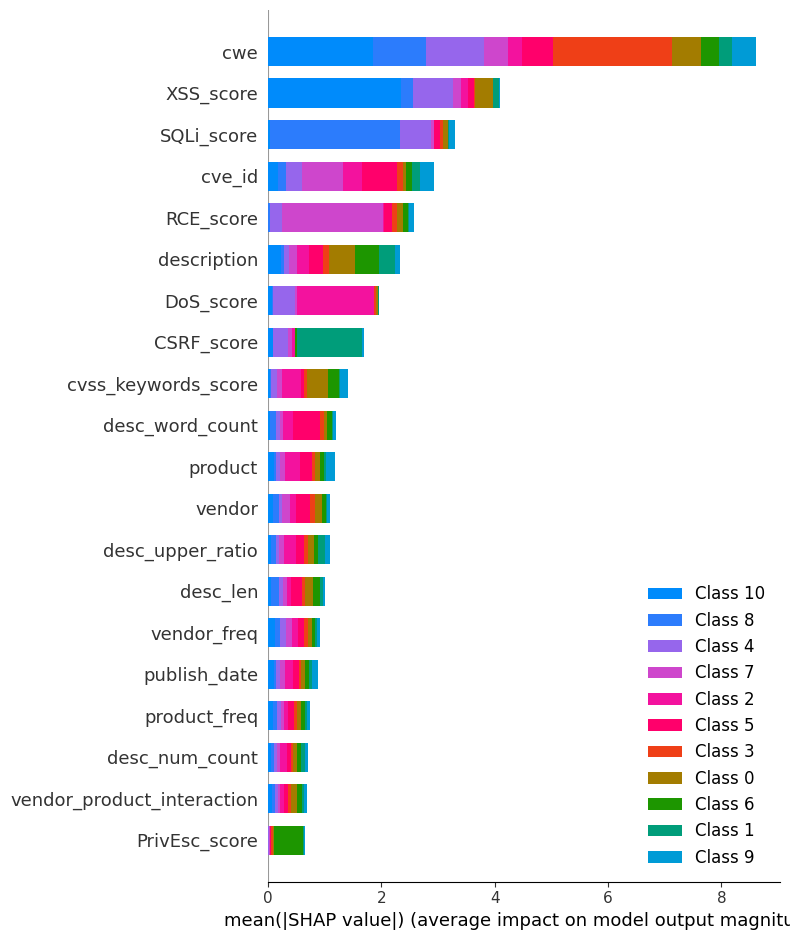

In [75]:
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)

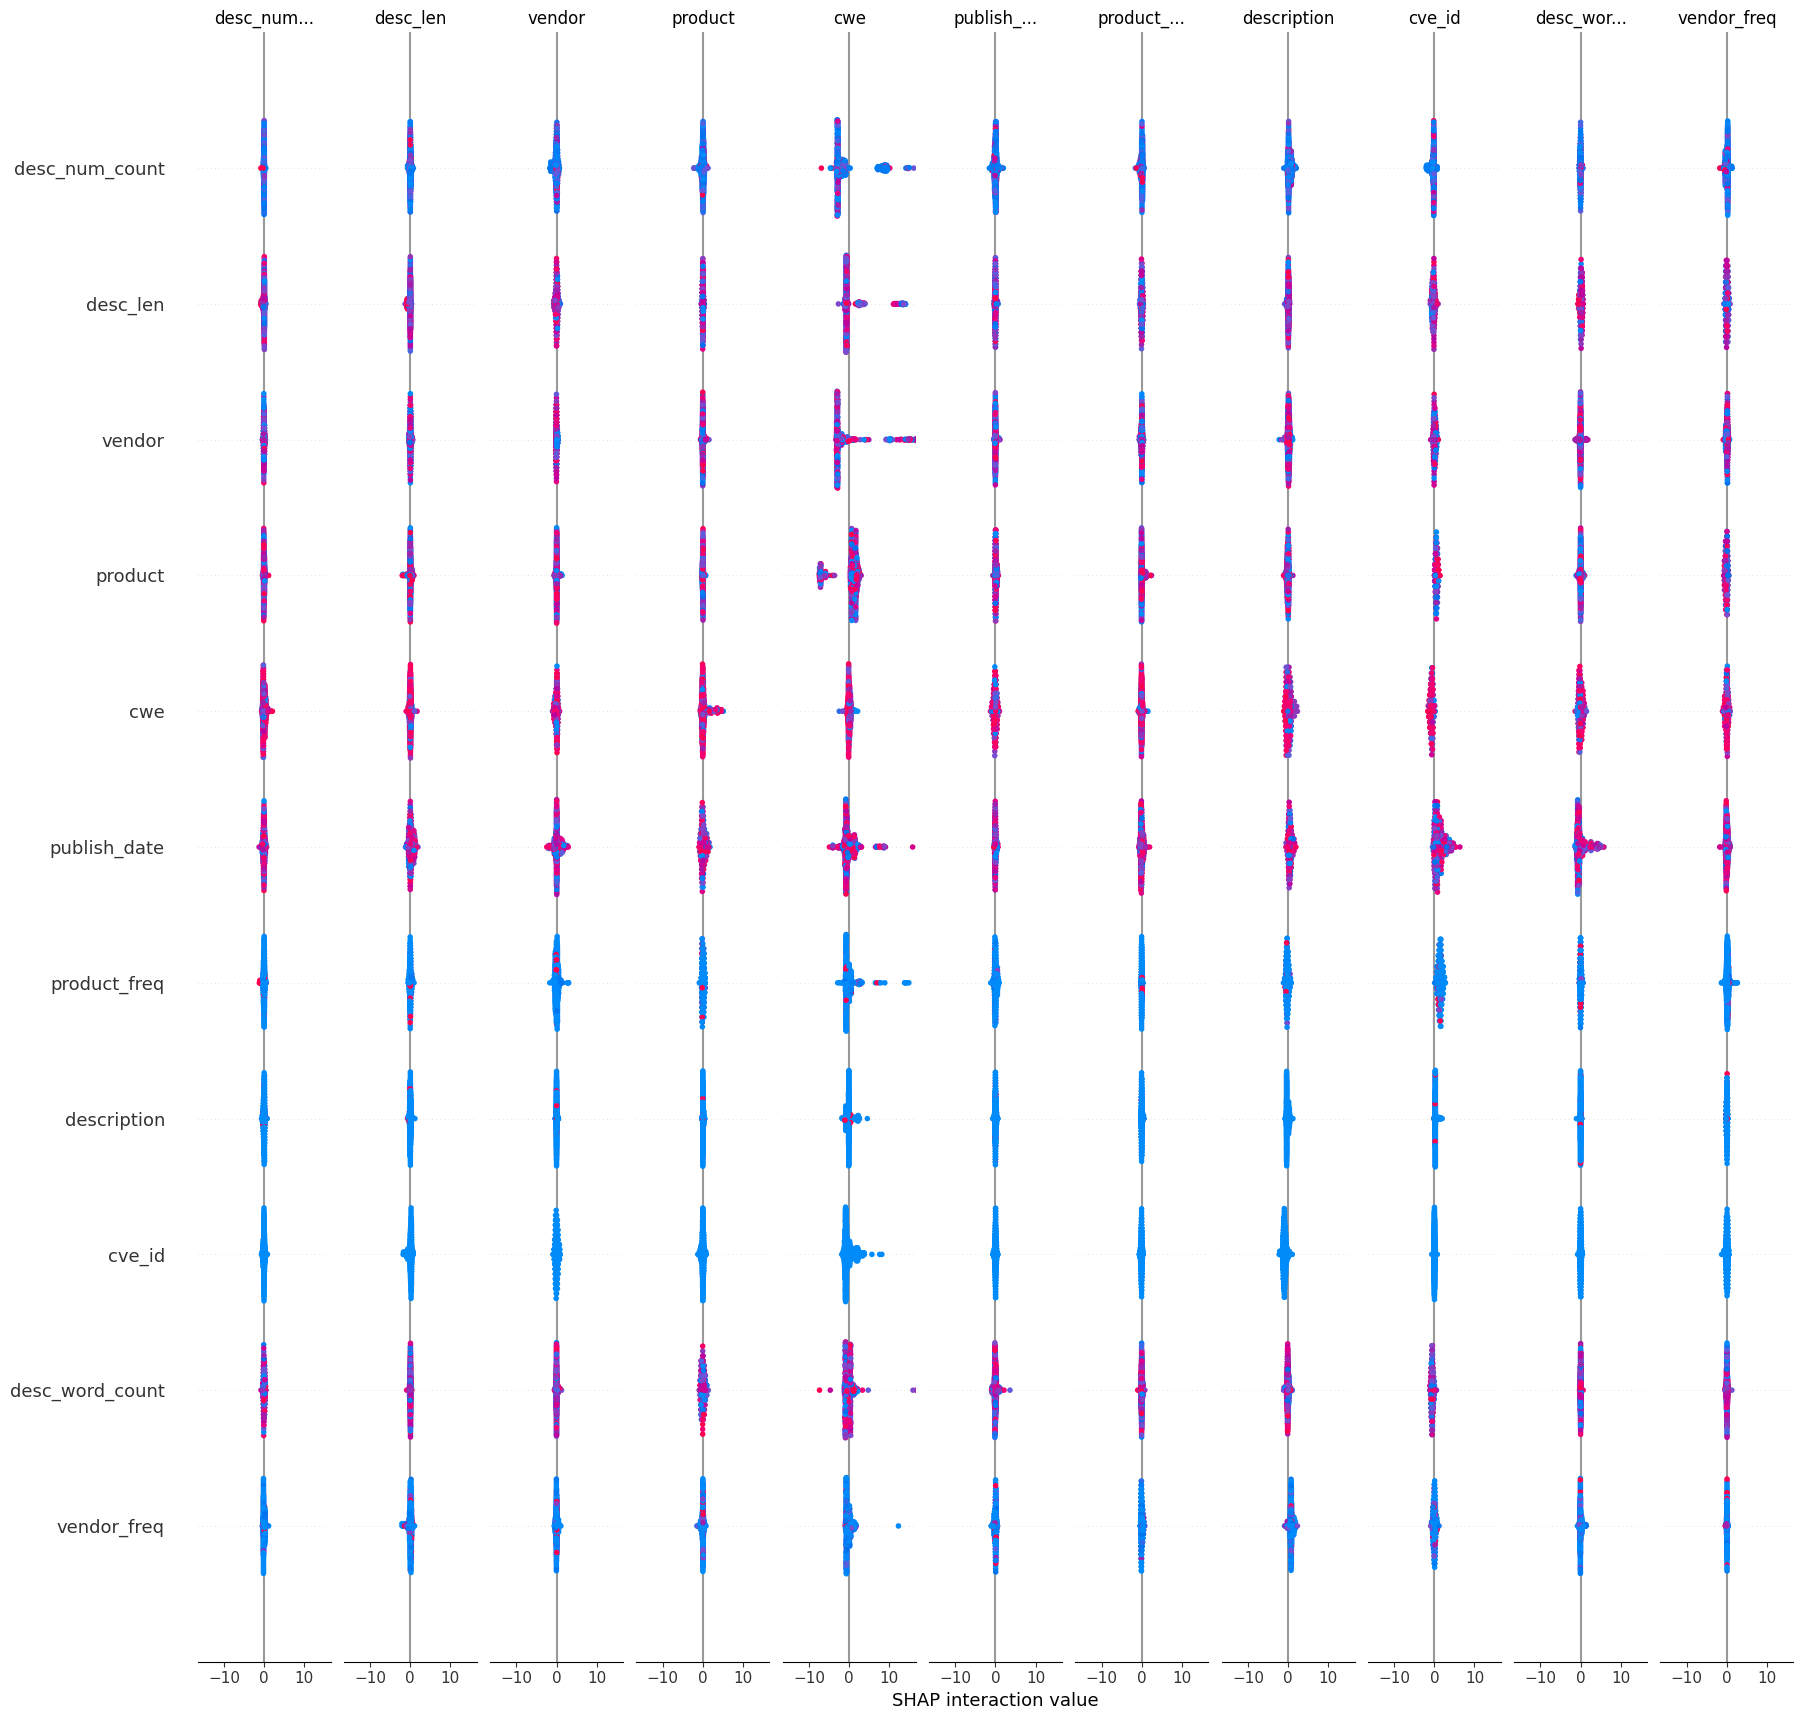

In [76]:
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    max_display=20
)

# Local SHAP

🔍 Local idx 11 | Prediction: XSS


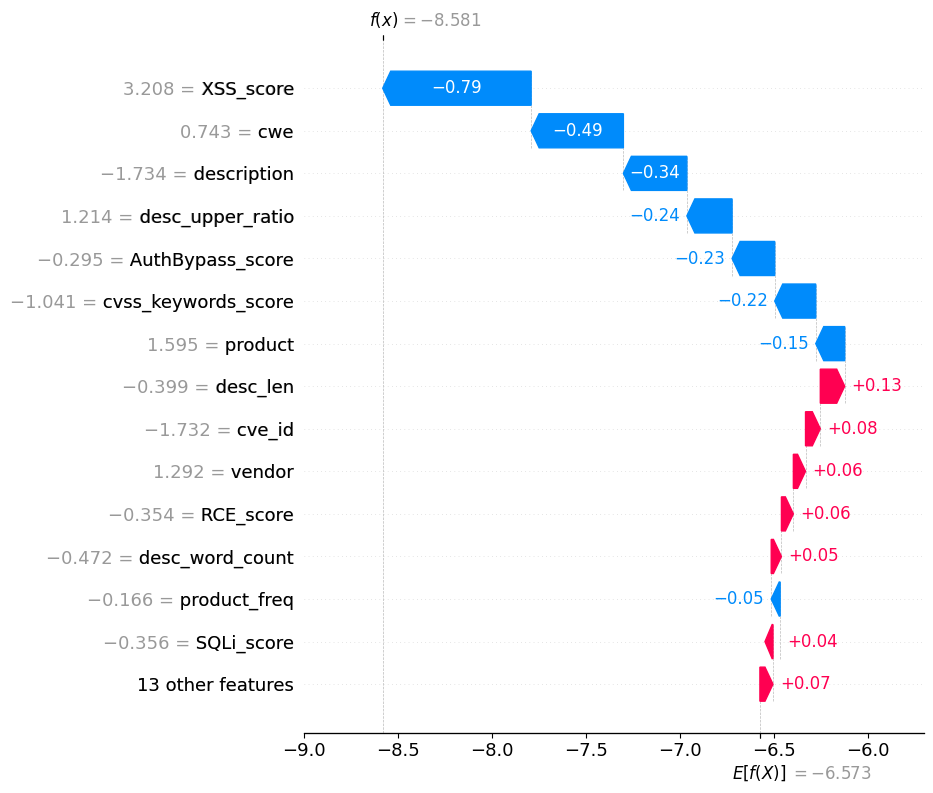

In [88]:
idx = 11
out_id = 0

pred = base_model.predict(X_sample[idx:idx+1])[0]
print(f"🔍 Local idx {idx} | Prediction: {pred}")

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[idx][:, out_id],
        base_values=explainer.expected_value[out_id],
        data=X_sample.iloc[idx].values,
        feature_names=feature_names
    ),
    max_display=15
)
